In [115]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json

import torch
from torch_geometric.nn import TransformerConv
from torch_geometric.transforms import  NormalizeFeatures, ToUndirected
from torch_geometric.data import Data
import torch_geometric as pyg
import torch.nn.functional as F
import networkx as nx
from sklearn.model_selection import train_test_split

In [116]:
class UniMP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, beta=True, heads=1):
        """
        Params:
        - input_dim: The dimension of input features for each node.
        - hidden_dim: The size of the hidden layers.
        - output_dim: The dimension of the output features (often equal to the
            number of classes in a classification task).
        - num_layers: The number of layer blocks in the model.
        - dropout: The dropout rate for regularization. It is used to prevent
            overfitting, helping the learning process remains generalized.
        - beta: A boolean parameter indicating whether to use a gated residual
            connection (based on equations 5 and 6 from the UniMP paper). The
            gated residual connection (controlled by the beta parameter) helps
            preventing overfitting by allowing the model to balance between new
            and existing node features across layers.
        - heads: The number of heads in the multi-head attention mechanism.
        """
        super(UniMP, self).__init__()

        # The list of transormer conv layers for the each layer block.
        self.num_layers = num_layers
        conv_layers = [TransformerConv(input_dim, hidden_dim//heads, heads=heads, beta=beta)]
        conv_layers += [TransformerConv(hidden_dim, hidden_dim//heads, heads=heads, beta=beta) for _ in range(num_layers - 2)]
        # In the last layer, we will employ averaging for multi-head output by
        # setting concat to True.
        conv_layers.append(TransformerConv(hidden_dim, output_dim, heads=heads, beta=beta, concat=True))
        self.convs = torch.nn.ModuleList(conv_layers)

        # The list of layerNorm for each layer block.
        norm_layers = [torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)]
        self.norms = torch.nn.ModuleList(norm_layers)

        # Probability of an element getting zeroed.
        self.dropout = dropout
    
    def reset_parameters(self):
        """
        Resets the parameters of the convolutional and normalization layers,
        ensuring they are re-initialized when needed.
        """
        for conv in self.convs:
            conv.reset_parameters()
        for norm in self.norms:
            norm.reset_parameters()

    def forward(self, x, edge_index):
        """
        The input features are passed sequentially through the transformer
        convolutional layers. After each convolutional layer (except the last),
        the following operations are applied:
        - Layer normalization (`LayerNorm`).
        - ReLU activation function.
        - Dropout for regularization.
        The final layer is processed without layer normalization and ReLU
        to average the multi-head results for the expected output.

        Params:
        - x: node features x
        - edge_index: edge indices.

        """
        for i in range(self.num_layers - 1):
            # Construct the network as shown in the model architecture.
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x)
            # By setting training to self.training, we will only apply dropout
            # during model training.
            x = F.dropout(x, p = self.dropout, training = self.training)

        # Last layer, average multi-head output.
        x = self.convs[-1](x, edge_index)

        return x

In [117]:
target_df = pd.read_csv('data/musae_git_target.csv')
edges_df = pd.read_csv('data/musae_git_edges.csv')

# load features
node_features_json = {}
with open(os.path.join("data/musae_git_features.json")) as json_file:
    node_features_json = json.load(json_file)

In [118]:
target_df['ml_target'].value_counts()

0    27961
1     9739
Name: ml_target, dtype: int64

In [119]:
# preprocessing

edge_index = []
node_features = []
node_labels = []

# Convert the edge_index to suitable format of [target, source]
for index, row in edges_df.iterrows():
    edge_index.append([row['id_1'], row['id_2']])

# Map the node features (x) and node labels (y)
for index, labels in target_df.iterrows():
    node_features.append(node_features_json[str(index)])
    node_labels.append(labels["ml_target"])
    
# Apply padding to node features to avoid shape errors
max_feature_size = 0
for i in node_features:
    max_feature_size = max(max_feature_size, len(i))

for i in range(len(node_features)):
    node_features[i] += [sum(node_features[i])/len(node_features[i])]*abs(max_feature_size-len(node_features[i]))

In [120]:
dataset = Data(x=torch.tensor(node_features, dtype=torch.float), 
               y=torch.tensor(node_labels, dtype=torch.float), 
               edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous())

dataset.y = dataset.y.long() 

dataset = ToUndirected()(dataset)
NormalizeFeatures()(dataset)

# Split nodes into training, validation, and test sets
train_idx, test_idx = train_test_split(range(int(dataset.num_nodes)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Create masks for training, validation, and test sets
train_mask = torch.zeros(dataset.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(dataset.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(dataset.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# Assign masks to the dataset
dataset.train_mask = train_mask
dataset.val_mask = val_mask
dataset.test_mask = test_mask

In [121]:
dataset

Data(x=[37700, 42], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

In [122]:
# Check maximum index in edge_index
max_index = dataset.edge_index.max().item()
min_index = dataset.edge_index.min().item()

print(f"Max index in edge_index: {max_index}")
print(f"Min index in edge_index: {min_index}")

# Check if indices are within valid range
assert max_index < 37700, "There are indices in edge_index that are out of the valid range."
assert min_index >= 0, "There are negative indices in edge_index."

Max index in edge_index: 37699
Min index in edge_index: 0


In [123]:
def node_drop_balance(data):
    # Only apply node dropping on the training set
    train_indices = data.train_mask.nonzero(as_tuple=False).view(-1)
    
    # Identify the majority and minority classes within the training set
    class_counts = torch.bincount(data.y[train_indices])
    majority_class = class_counts.argmax().item()
    minority_class = class_counts.argmin().item()
    
    # Get indices of majority and minority class nodes within the training set
    majority_class_indices = train_indices[data.y[train_indices] == majority_class]
    minority_class_indices = train_indices[data.y[train_indices] == minority_class]
    
    # Calculate the number of nodes to drop from the majority class
    num_to_drop = len(majority_class_indices) - len(minority_class_indices)
    
    if num_to_drop > 0:
        # Randomly select nodes to drop from the majority class
        drop_indices = torch.randperm(len(majority_class_indices))[:num_to_drop]
        drop_nodes = majority_class_indices[drop_indices]
        
        # Create a mask to keep nodes that are not dropped
        keep_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        keep_mask[drop_nodes] = False
        
        # Apply the mask to the training set nodes and update the training mask
        new_train_mask = data.train_mask.clone()
        new_train_mask[drop_nodes] = False
        
        new_data = Data(x=data.x, edge_index=data.edge_index, y=data.y,
                        train_mask=new_train_mask, val_mask=data.val_mask, test_mask=data.test_mask)
        
        return new_data
    else:
        return data  # No need to drop nodes if the classes are already balanced

In [124]:
# Define the Training and Testing Functions

from torch.optim import Adam
from sklearn.metrics import f1_score

# Apply node dropping to the training set only
dataset = node_drop_balance(dataset)

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    # Apply the mask to select only the training nodes and their corresponding labels
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        y_pred_train = out[data.train_mask].argmax(dim=-1, keepdim=False)
        train_acc = int((y_pred_train == data.y[data.train_mask]).sum()) / y_pred_train.size(0)

        y_pred_val = out[data.val_mask].argmax(dim=-1, keepdim=False)
        val_acc = int((y_pred_val == data.y[data.val_mask]).sum()) / y_pred_val.size(0)

        # For best model
        val_f1 = f1_score(data.y[data.val_mask], y_pred_val)

        y_pred_test = out[data.test_mask].argmax(dim=-1, keepdim=False)
        test_acc = int((y_pred_test == data.y[data.test_mask]).sum()) / y_pred_test.size(0)

    return train_acc, val_acc, test_acc, val_f1


In [125]:
# Initialize the Model, Optimizer, and Loss Function

configs = {
      'num_layers': 3,
      'input_dim': dataset.num_features,
      'output_dim': 2, # number of classes
      'hidden_dim': 64,
      'num_heads': 1,
      'dropout': 0.3,
      'lr':  0.0001,
      'epochs': 500,
      'weight_decay': 0.0005,
      'batch_size': 64
  }

model = UniMP(configs['input_dim'], configs['hidden_dim'], 
              configs['output_dim'], configs['num_layers'],
              configs['dropout'], heads=configs['num_heads'])

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'], weight_decay=configs['weight_decay'])

criterion = torch.nn.CrossEntropyLoss()

In [126]:
import torch.nn as nn

best_val_f1 = 0
losses, train_accs, valid_accs, test_accs = [], [], [], []

# Apply node dropping once before training
dataset_balanced = node_drop_balance(dataset)

for epoch in range(1, configs['epochs'] + 1):
    train_loss = train(model, dataset_balanced, optimizer, criterion)
    result = test(model, dataset_balanced)
    #print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    train_acc, val_acc, test_acc, val_f1 = result

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")

    losses.append(train_loss)
    train_accs.append(train_acc)
    valid_accs.append(val_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch: {epoch:02d}, '
        f'Loss: {train_loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * val_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Saved best model
Epoch: 01, Loss: 0.7029, Train: 48.32%, Valid: 32.08% Test: 32.23%
Epoch: 02, Loss: 0.7054, Train: 47.73%, Valid: 34.97% Test: 35.61%
Epoch: 03, Loss: 0.7031, Train: 47.27%, Valid: 37.44% Test: 38.14%
Epoch: 04, Loss: 0.7023, Train: 47.70%, Valid: 39.79% Test: 40.49%
Epoch: 05, Loss: 0.7014, Train: 48.14%, Valid: 42.63% Test: 42.80%
Epoch: 06, Loss: 0.7023, Train: 47.88%, Valid: 44.64% Test: 45.11%
Epoch: 07, Loss: 0.7028, Train: 48.15%, Valid: 46.49% Test: 46.39%
Epoch: 08, Loss: 0.7031, Train: 48.47%, Valid: 48.17% Test: 47.51%
Epoch: 09, Loss: 0.7012, Train: 48.75%, Valid: 48.57% Test: 48.37%
Epoch: 10, Loss: 0.6991, Train: 49.33%, Valid: 48.30% Test: 48.01%
Epoch: 11, Loss: 0.6981, Train: 49.73%, Valid: 48.06% Test: 47.75%
Epoch: 12, Loss: 0.7034, Train: 50.27%, Valid: 47.98% Test: 48.01%
Epoch: 13, Loss: 0.6980, Train: 50.49%, Valid: 47.36% Test: 47.47%
Epoch: 14, Loss: 0.6975, Train: 50.48%, Valid: 46.82% Test: 47.11%
Epoch: 15, Loss: 0.6966, Train: 50.85%, Valid

In [138]:
from sklearn.metrics import precision_recall_fscore_support

# Load the best model and test
model.load_state_dict(torch.load('best_model.pth'))

out = model(dataset.x, dataset.edge_index)
y_pred = out[dataset.test_mask].argmax(dim=-1, keepdim=False)
y_true = dataset.y[dataset.test_mask]

# considering avg f1 score between the two classes
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted") 

print("Performance on test set:")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Performance on test set:
Precision: 0.8057583139232778
Recall: 0.7924403183023873
F1: 0.7973919890717894


In [129]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.83      0.85      5556
     class 1       0.59      0.69      0.64      1984

    accuracy                           0.79      7540
   macro avg       0.74      0.76      0.75      7540
weighted avg       0.81      0.79      0.80      7540



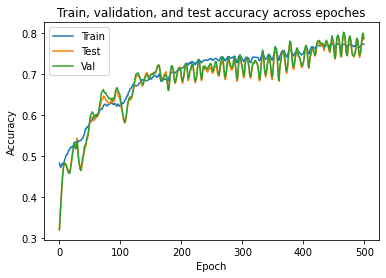

In [131]:
x = np.arange(configs['epochs'])

plt.plot(x, train_accs, label = "Train")
plt.plot(x, test_accs, label = "Test")
plt.plot(x, valid_accs, label = "Val")

plt.title("Train, validation, and test accuracy across epoches")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


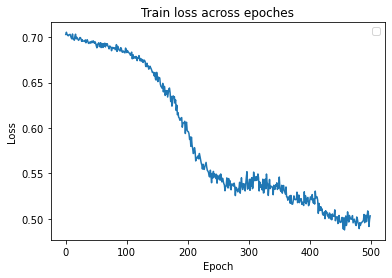

In [132]:
x = np.arange(configs['epochs'])

plt.plot(x, losses)

plt.title("Train loss across epoches")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()